#### AMOC references

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000644

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015RG000493

when a single-value AMOC number is required, the maximum at 26N is meant. 


## Step 1, calculate AMOC using CDFtools

### process annotation

`module add gcc/10.3.0`

`module add netcdf/4.7.4/gcc`

toolbox is here: `cd /gpfs/home/mep22dku/cdftools`

need to symlink orca meshmask:

do  `bash link_tommask.sh`

bashscript for running the toolbox is in `overturning_TOM.sh` in the toolbox directory (change model name!)

it puts results in `/gpfs/home/mep22dku/cdftools/MOCresults` with name of run in filename

In [13]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

note: I am calculating the overturning from TOM12_TJ_GE{A-D}0, not TOM12_TJ_GE{A-D}1, as I didn't save the grid_V files for the latter. The difference in the two runs is only a change in the biogeochemistry, and looking at the temperature distribution, it is identical in the atlantic (and only does small numerical-looking effects in the pacific at the surface), and thus the AMOC calculation will be the same:

Text(0.5, 1.0, 'random year and month, zlevel = 0 votemper, difference between GEA1 and GEA0')

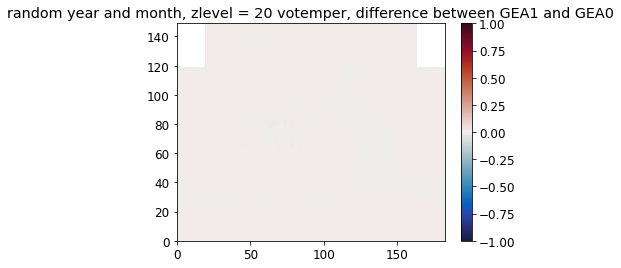

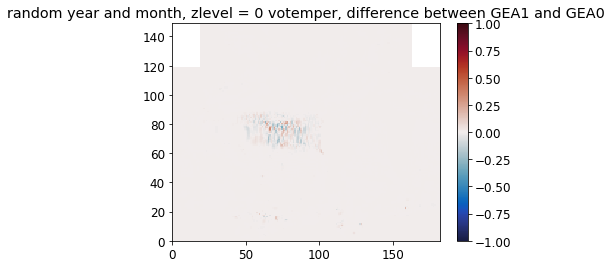

In [27]:
tdat = xr.open_dataset('/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_GEA1/ORCA2_1m_20200101_20201231_grid_T.nc')

tdat2 = xr.open_dataset('/gpfs/home/mep22dku/scratch/ModelRuns/TOM12_TJ_GEA0/ORCA2_1m_20200101_20201231_grid_T.nc')

plt.figure()
w = plt.pcolormesh(tdat.votemper[1,20,:,:] - tdat2.votemper[1,20,:,:], vmin = -1, vmax = 1, cmap = cm.balance)
plt.colorbar(w)
plt.title('random year and month, zlevel = 20 votemper, difference between GEA1 and GEA0')

plt.figure()
w = plt.pcolormesh(tdat.votemper[1,0,:,:] - tdat2.votemper[1,0,:,:], vmin = -1, vmax = 1, cmap = cm.balance)
plt.colorbar(w)
plt.title('random year and month, zlevel = 0 votemper, difference between GEA1 and GEA0')

# plt.pcolormesh(

## calculate and save maximum overturning

In [30]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl


## change A, B, C, D simulations here if running for a different e

In [59]:
GEA0_moc = make_yearlist(1959, 2022, 'TOM12_TJ_GEA0')
GEB0_moc = make_yearlist(1959, 2022, 'TOM12_TJ_GEB0')
GEC0_moc = make_yearlist(1959, 2022, 'TOM12_TJ_GEC0')
GED0_moc = make_yearlist(1959, 2022, 'TOM12_TJ_GED0')

GEA0_mocdat = xr.open_mfdataset(GEA0_moc) 
GEB0_mocdat = xr.open_mfdataset(GEB0_moc) 
GEC0_mocdat = xr.open_mfdataset(GEC0_moc) 
GED0_mocdat = xr.open_mfdataset(GED0_moc) 

GEA0_max_amoc = get_max_amoc(GEA0_mocdat)
GEB0_max_amoc = get_max_amoc(GEB0_mocdat)
GEC0_max_amoc = get_max_amoc(GEC0_mocdat)
GED0_max_amoc = get_max_amoc(GED0_mocdat)

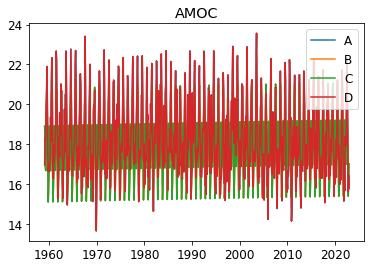

In [61]:
nicetime  = GEA0_mocdat.indexes['time_counter'].to_datetimeindex()
plt.plot(nicetime, GEA0_max_amoc, label = 'A')
plt.plot(nicetime, GEB0_max_amoc, label = 'B')
plt.plot(nicetime, GEC0_max_amoc, label = 'C')
plt.plot(nicetime, GED0_max_amoc, label = 'D')
plt.title('AMOC')
plt.legend()

In [55]:
import arrow

def make_amoc_nc(nicetime, tdat, simulationID, yrFrom = 1959, yrTo = 2022):

    utc = arrow.utcnow()
    timestamp = utc.format('YYYYMMDD')
    resultsdir = '/gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/'
    parm = 'AMOC'
    outputFile = f'{resultsdir}{parm}_PlankTOM_{simulationID}_1_gr_{yrFrom}-{yrTo}_v{timestamp}.nc'
    data_vars = {'AMOC':(['TIME'], tdat,
    {'units': 'Sv',
    'long_name':'Atlantic Meridional Overturning Circulation'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2023/scripts/makeAMOC.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)
    


In [62]:
savehorse = False
if savehorse:
    
    make_amoc_nc(nicetime, GEA0_max_amoc, 'A')
    make_amoc_nc(nicetime, GEB0_max_amoc, 'B')
    make_amoc_nc(nicetime, GEC0_max_amoc, 'C')
    make_amoc_nc(nicetime, GED0_max_amoc, 'D')

## check that plotted values make sense!

In [63]:
w = xr.open_dataset('//gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/AMOC_PlankTOM_A_1_gr_1959-2022_v20230707.nc')

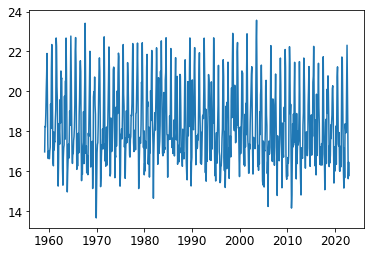

In [64]:
plt.plot(w.TIME, w.AMOC)